<a href="https://colab.research.google.com/github/raulbenitez/DEEPCARDIO/blob/master/sparks/train/inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive") # , force_remount=True) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as kb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

# Insert the directory
import sys
sys.path.insert(0, 'drive/MyDrive/tfm/DEEPCARDIO_drive/sparks')
# ! ls drive/MyDrive/tfm/DEEPCARDIO_drive/sparks/train

In [ ]:
from train.inception import load_data, _recall_and_false_spark, sigmoid_spark_and_non_spark_loss, _sigmoid, sigmoid_loss

filesPath = 'drive/MyDrive/tfm/DEEPCARDIO_drive/sparks/train/'

In [ ]:
X_train, Y_train, X_test, Y_test = load_data(classesFromFile=True, imageFolder='drive/MyDrive/tfm/DEEPCARDIO_drive/_datasets/deepcardio/170215_RyR-GFP30_RO_01_Serie2_SPARKS-calcium', gaussianFilter=False)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

Prop of sparks in train dataset: 14.92, and in validation dataset: 14.6


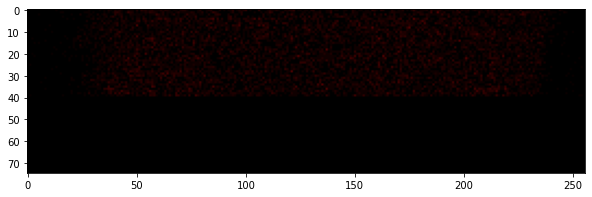

In [ ]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weight_array = compute_class_weight('balanced', np.unique(Y_train), Y_train.argmax(axis=-1))
weight_dict = dict(zip(np.unique(Y_train), weight_array))
weight_dict

{0.0: 0.5867460908413998, 1.0: 3.3819742489270386}

In [ ]:
# Inception V3
modelv3 = keras.applications.InceptionV3(include_top=True, weights=None, classes=2, input_shape=X_train[0].shape)
# modelv3.summary()

batch_size = 256
epochs = 300

# custom functions
loss_function='categorical_crossentropy'
loss_function_str = loss_function.__name__ if not isinstance(loss_function, str) else loss_function
recallRatio = 0.6
metric_function = _recall_and_false_spark(recallRatio)

# trainID = f"inceptionv3_ep{epochs}_batch{batch_size}__{recallRatio}{metric_function.__name__}__{loss_function_str}__classWeights"
trainID = f"inceptionv3_ep{epochs}_batch{batch_size}__{loss_function_str}__classWeights"
print('trainId: '+trainID)

opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
# modelv3.compile(loss=loss_function, optimizer='adam', metrics=[metric_function])
modelv3.compile(loss=loss_function, optimizer='adam')

modelv3.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_valid), shuffle=True, class_weight=weight_dict)

modelv3.save(f"{filesPath}{trainID}.h5")

plt.figure(figsize=(20, 5))
plt.plot(modelv3.history.history[f"{metric_function.__name__}"])
plt.plot(modelv3.history.history[f"val_{metric_function.__name__}"])
plt.legend(['train', 'valid'])
plt.savefig(f"{filesPath}{trainID}_metrics.png")
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(modelv3.history.history['loss'])
plt.plot(modelv3.history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.savefig(f"{filesPath}{trainID}_loss.png")
plt.show()

Y_test_pred = modelv3.predict(X_test)
Y_valid_pred = modelv3.predict(X_valid)

confMatrix = confusion_matrix(Y_valid.argmax(axis=1), Y_valid_pred.argmax(axis=1), normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(confMatrix, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot=True)
plt.title('confusion matrix validation')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()
print("Classification report validation:\n",  classification_report(Y_valid.argmax(axis=1), Y_valid_pred.argmax(axis=1), target_names=class_labels))

confMatrix = confusion_matrix(Y_test.argmax(axis=1), Y_test_pred.argmax(axis=1), normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(confMatrix, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot=True)
plt.title('confusion matrix test')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()
print("Classification report test:\n",  classification_report(Y_test.argmax(axis=1), Y_test_pred.argmax(axis=1), target_names=class_labels))

trainId: inceptionv3_ep300_batch256__categorical_crossentropy__classWeights
Epoch 1/300
7/7 [==============================] - 11s 765ms/step - loss: 1.0194 - val_loss: 0.5387
Epoch 2/300
7/7 [==============================] - 4s 590ms/step - loss: 0.5019 - val_loss: 0.4391
Epoch 3/300
7/7 [==============================] - 4s 597ms/step - loss: 0.3025 - val_loss: 0.4482
Epoch 4/300
7/7 [==============================] - 4s 597ms/step - loss: 0.1802 - val_loss: 0.5592
Epoch 5/300
7/7 [==============================] - 4s 598ms/step - loss: 0.1904 - val_loss: 0.6343
Epoch 6/300
7/7 [==============================] - 4s 600ms/step - loss: 0.1488 - val_loss: 0.7035
Epoch 7/300
7/7 [==============================] - 4s 605ms/step - loss: 0.0933 - val_loss: 0.7276
Epoch 8/300
7/7 [==============================] - 4s 609ms/step - loss: 0.1057 - val_loss: 0.8283
Epoch 9/300
7/7 [==============================] - 4s 613ms/step - loss: 0.0908 - val_loss: 0.9247
Epoch 10/300
7/7 [==============

KeyError: ignored

<Figure size 1440x360 with 0 Axes>

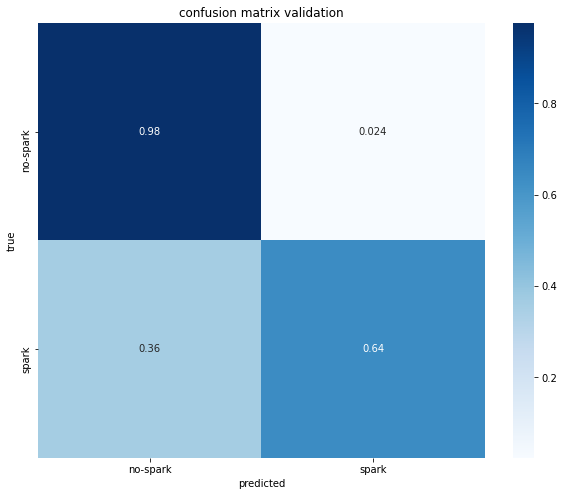

Classification report validation:
               precision    recall  f1-score   support

    no-spark       0.94      0.98      0.96       334
       spark       0.83      0.64      0.72        61

    accuracy                           0.92       395
   macro avg       0.88      0.81      0.84       395
weighted avg       0.92      0.92      0.92       395



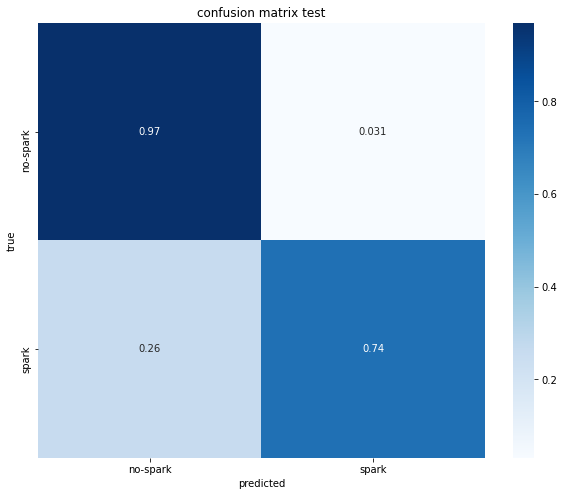

Classification report test:
               precision    recall  f1-score   support

    no-spark       0.96      0.97      0.96       421
       spark       0.80      0.74      0.77        72

    accuracy                           0.94       493
   macro avg       0.88      0.85      0.87       493
weighted avg       0.93      0.94      0.93       493



In [ ]:
class_labels = ['no-spark', 'spark']

Y_test_pred = modelv3.predict(X_test)
Y_valid_pred = modelv3.predict(X_valid)

confMatrix = confusion_matrix(Y_valid.argmax(axis=1), Y_valid_pred.argmax(axis=1), normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(confMatrix, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot=True)
plt.title('confusion matrix validation')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()
print("Classification report validation:\n",  classification_report(Y_valid.argmax(axis=1), Y_valid_pred.argmax(axis=1), target_names=class_labels))

confMatrix = confusion_matrix(Y_test.argmax(axis=1), Y_test_pred.argmax(axis=1), normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(confMatrix, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot=True)
plt.title('confusion matrix test')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()
print("Classification report test:\n",  classification_report(Y_test.argmax(axis=1), Y_test_pred.argmax(axis=1), target_names=class_labels))

In [ ]:
bplt.figure(figsize=(20, 5))
plt.plot(modelv3.history.history[f"{metric_function.__name__}"])
plt.plot(modelv3.history.history[f"val_{metric_function.__name__}"])
plt.legend(['train', 'valid'])
plt.savefig(f"{filesPath}{trainID}_metrics.png")
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(modelv3.history.history['loss'])
plt.plot(modelv3.history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.savefig(f"{filesPath}{trainID}_loss.png")
plt.show()

KeyError: ignored

<Figure size 1440x360 with 0 Axes>